In [11]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

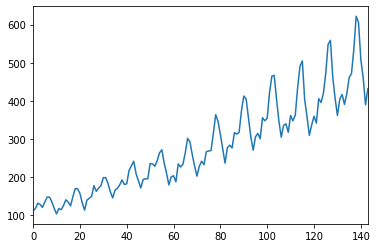

In [24]:
df = sns.load_dataset('flights')
df['passengers'].plot()

### 1. Train a vanilla LinReg model (no feature engineering)

In [60]:
df['x'] = range(144)

X = df[['x']]
y = df['passengers']

In [8]:
m = LinearRegression()
m.fit(X, y)
m.score(X, y)

0.853638165603188

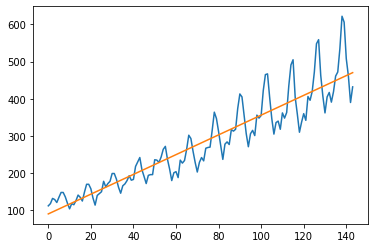

In [12]:
ypred = m.predict(X)
plt.plot(df['x'], y)
plt.plot(df['x'], ypred)

**Disadvantage: This model sucks!**

### 2. Feature Expansion: One-Hot-Encoding

In [15]:
df2 = pd.concat([df, pd.get_dummies(df['month'])], axis=1)
df2.head()

,year,month,passengers,x,January,February,March,April,May,June,July,August,September,October,November,December
0,1949,January,112,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1949,February,118,1,0,1,0,0,0,0,0,0,0,0,0,0
2,1949,March,132,2,0,0,1,0,0,0,0,0,0,0,0,0
3,1949,April,129,3,0,0,0,1,0,0,0,0,0,0,0,0
4,1949,May,121,4,0,0,0,0,1,0,0,0,0,0,0,0


In [16]:
X = df2.iloc[:, 3:]
X.shape

(144, 13)

In [17]:
m = LinearRegression()
m.fit(X, y)
m.score(X, y)  # much better!

0.9558707271418253

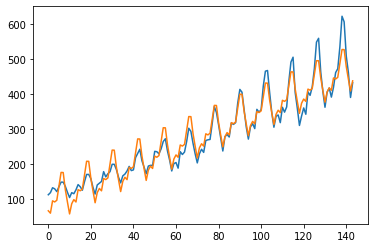

In [18]:
ypred = m.predict(X)
plt.plot(df['x'], y)
plt.plot(df['x'], ypred)

**Advantage: Much more accurate**
    
**Disadvantage: discrete; we need 13 features!**

## 3. Feature Expansion: Radial Base Functions (RBF)

In [30]:
def rbf(x, width, mean):
    return np.exp(-(x - mean)**2 / (2 * width))

def rbf_transform(column, freq, width, prefix='rbf_'):
    """Returns RBF-encoded features"""
    result = {}
    x = np.arange(df.shape[0])
    for i in range(0, freq):
        result[f'{prefix}{i}'] = np.zeros(df.shape[0])
        j = -freq
        while j <= df.shape[0]:
            result[f'{prefix}{i}'] += rbf(x, width, i + j)
            j += freq
    return pd.DataFrame(result)

#### Create multiple RBF columns 
This is a smoother one-hot encoding

In [69]:
rbf_transform(df, freq=12, width=9).head()

,rbf_0,rbf_1,rbf_2,rbf_3,rbf_4,rbf_5,rbf_6,rbf_7,rbf_8,rbf_9,rbf_10,rbf_11
0,1.000671,0.947247,0.804622,0.617643,0.439678,0.315081,0.270671,0.315081,0.439678,0.617640,0.804603,0.947163
1,0.947247,1.000671,0.947247,0.804622,0.617643,0.439678,0.315081,0.270671,0.315081,0.439678,0.617640,0.804603
2,0.804622,0.947247,1.000671,0.947247,0.804622,0.617643,0.439678,0.315081,0.270671,0.315081,0.439678,0.617640
3,0.617643,0.804622,0.947247,1.000671,0.947247,0.804622,0.617643,0.439678,0.315081,0.270671,0.315081,0.439678
4,0.439678,0.617643,0.804622,0.947247,1.000671,0.947247,0.804622,0.617643,0.439678,0.315081,0.270671,0.315081


#### use Scikit ColumnTransformer to use fit_transform

In [71]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from functools import partial

# define the transformer
pfunc = partial(rbf_transform, freq=12, width=9, prefix='month')
rbf_trans = FunctionTransformer(pfunc, validate=False)

preprocessor = ColumnTransformer([('rbf', rbf_trans, [1])], remainder='passthrough')

In [73]:
df3 = df[['x', 'month']]

X = preprocessor.fit_transform(df3)
m = LinearRegression()
m.fit(X, y)
m.score(X, y)  # slightly better than 1hot

0.9585855678217399

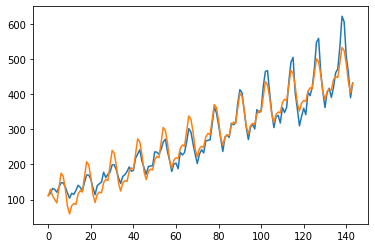

In [74]:
ypred = m.predict(X)
plt.plot(df['x'], y)
plt.plot(df['x'], ypred)

In [78]:
### 4. Leave away some columns
Xt = X[:,::3]
Xt.shape

(144, 5)

In [80]:
m = LinearRegression()
m.fit(Xt, y)
m.score(Xt, y)  # almost same score with 5 features

0.9403349735932449

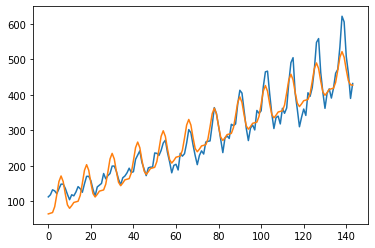

In [82]:
ypred = m.predict(Xt)
plt.plot(df['x'], y)
plt.plot(df['x'], ypred)

In [ ]:
**

### Plot a single RBF

In [95]:
x = np.arange(144)
y = rbf(x, 40, 60)
y2 = rbf(x, 40, 70)

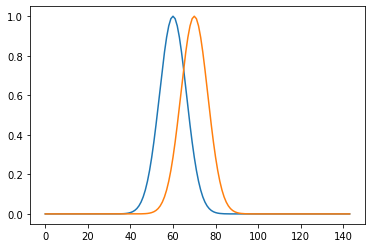

In [96]:
from matplotlib import pyplot as plt
plt.plot(x, y)
plt.plot(x, y2)

----

### Polynomial and Interaction Terms

In [123]:
from sklearn.preprocessing import PolynomialFeatures

In [136]:
X = pd.DataFrame({
      'a':[1.0, 2.0, 3.0, 4.0]})
      #'b':[1.0, 2.0, 0.0]})
X

,a
0,1.0
1,2.0
2,3.0
3,4.0


In [138]:
m = PolynomialFeatures(degree=5)
pd.DataFrame(m.fit_transform(X))

,0,1,2,3,4,5
0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,2.0,4.0,8.0,16.0,32.0
2,1.0,3.0,9.0,27.0,81.0,243.0
3,1.0,4.0,16.0,64.0,256.0,1024.0


In [134]:
m = PolynomialFeatures(degree=2)
pd.DataFrame(m.fit_transform(X), columns=['a0b0', 'a1b0', 'a0b1', 'a2b0', 'a0b2', 'a1b1'])

,a0b0,a1b0,a0b1,a2b0,a0b2,a1b1
0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,2.0,2.0,4.0,4.0,4.0
2,1.0,3.0,0.0,9.0,0.0,0.0


In [131]:
m = PolynomialFeatures(interaction_only=True)
pd.DataFrame(m.fit_transform(X), columns=['a0b0', 'a1b0', 'a0b1', 'a1b1'])

,a0b0,a1b0,a0b1,a1b1
0,1.0,1.0,1.0,1.0
1,1.0,2.0,2.0,4.0
2,1.0,3.0,0.0,0.0
